📘 Title: Tracing the Bruno Constant: Profiling Collapse Signatures in Tokamak Data

- Purpose: Detect and analyze the emergence of the Bruno constant in high-energy system outputs (e.g. Tokamak traces).
- Goal: Identify statistical/correlative features (mean, std, min/max ratios, binary patterns, duration...) that might prefigure entropy collapse.
- Inputs: Processed signal CSVs, previous stats, known anomalies.
- Hypothesis: Bruno constant manifests as a specific constraint on entropy-rich signals.


In [64]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [65]:
data_dir = "traces_out"
files = sorted([f for f in os.listdir(data_dir) if f.endswith(".csv")])
traces = {}

for file in files:
    df = pd.read_csv(os.path.join(data_dir, file))
    if 'time' in df.columns and 'ax' in df.columns:
        norm_signal = (df['ax'] - df['ax'].mean()) / df['ax'].std()
        traces[file] = {
            "time": df['time'],
            "signal": norm_signal
        }


In [66]:
def extract_features(signal_df):
    time = signal_df['time']
    ax = signal_df['signal']
    return {
        "min": ax.min(),
        "max": ax.max(),
        "mean": ax.mean(),
        "std": ax.std(),
        "duration": time.max() - time.min(),
        "zero_crossings": ((ax.shift(1) * ax) < 0).sum(),
        "looks_binary": ax.nunique() < 5
    }

trace_stats = {name: extract_features(pd.DataFrame(data)) for name, data in traces.items()}
trace_stats_df = pd.DataFrame.from_dict(trace_stats, orient='index')



In [61]:
plt.figure(figsize=(10, 6))
sns.heatmap(trace_stats_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix of Signal Features")
plt.show()


ValueError: zero-size array to reduction operation fmin which has no identity

<Figure size 1000x600 with 0 Axes>

In [62]:
trace_stats_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Empty DataFrame


In [63]:
sns.heatmap(trace_stats_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix of Signal Features")
plt.show()


ValueError: zero-size array to reduction operation fmin which has no identity

In [68]:
import pandas as pd
import os

# Pick one file manually for inspection
test_file = "traces_out/20ja074_fig01a_data_step_1.signal.csv"

# Check if it exists
print("Exists:", os.path.exists(test_file))

# Read raw content
with open(test_file, "r") as f:
    print("First 5 lines:")
    for _ in range(5):
        print(f.readline())

# Try loading with pandas
try:
    df = pd.read_csv(test_file)
    print("\nPandas loaded shape:", df.shape)
    print(df.head())
except Exception as e:
    print("❌ Pandas failed to read file:", e)


Exists: True
First 5 lines:
time,value

0.7000000000000001,3.6087076556862807

0.7100000000000001,3.5853411805714925

0.7200000000000001,3.5797343980747045

0.7300000000000001,3.5267871113228284


Pandas loaded shape: (158, 2)
   time     value
0  0.70  3.608708
1  0.71  3.585341
2  0.72  3.579734
3  0.73  3.526787
4  0.74  3.299474


PART 2 TRY

In [69]:
import pandas as pd
import os
import glob

trace_stats = []

for file in glob.glob("traces_out/*.signal.csv"):
    try:
        df = pd.read_csv(file)  # <- Default assumes header=True
        time = df['time']
        signal = df['value']

        stats = {
            "trace_id": os.path.basename(file),
            "min": signal.min(),
            "max": signal.max(),
            "mean": signal.mean(),
            "std": signal.std(),
            "duration": time.max() - time.min(),
            "looks_binary": signal.nunique() < 5
        }

        trace_stats.append(stats)

    except Exception as e:
        print(f"❌ Failed to profile {file}: {e}")

# Save to DataFrame
trace_stats_df = pd.DataFrame(trace_stats)
trace_stats_df.info()  # Check that it's no longer empty


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   trace_id      41 non-null     object 
 1   min           41 non-null     float64
 2   max           41 non-null     float64
 3   mean          41 non-null     float64
 4   std           41 non-null     float64
 5   duration      41 non-null     float64
 6   looks_binary  41 non-null     bool   
dtypes: bool(1), float64(5), object(1)
memory usage: 2.1+ KB


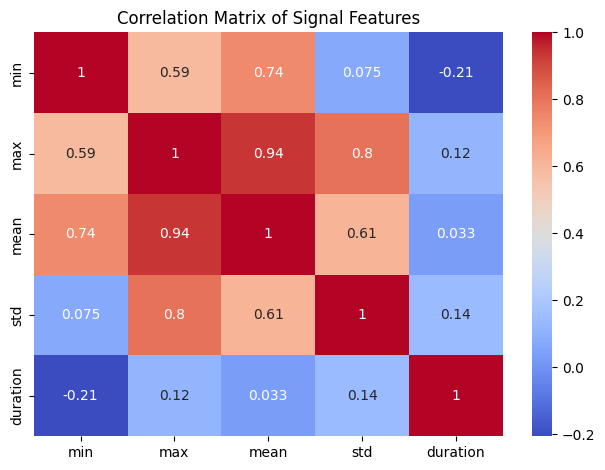

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

# Drop non-numeric columns like 'trace_id'
numeric_df = trace_stats_df.select_dtypes(include=['number'])

# Plot heatmap
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix of Signal Features")
plt.tight_layout()
plt.show()


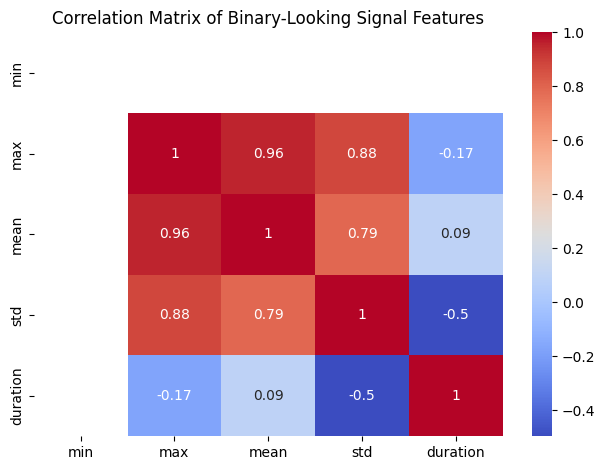

In [72]:
# Filter only the binary-looking signals
binary_df = trace_stats_df[trace_stats_df["looks_binary"] == True]

# Drop non-numeric columns for correlation
binary_numeric = binary_df.select_dtypes(include=["number"])

# Plot heatmap
sns.heatmap(binary_numeric.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix of Binary-Looking Signal Features")
plt.tight_layout()
plt.show()


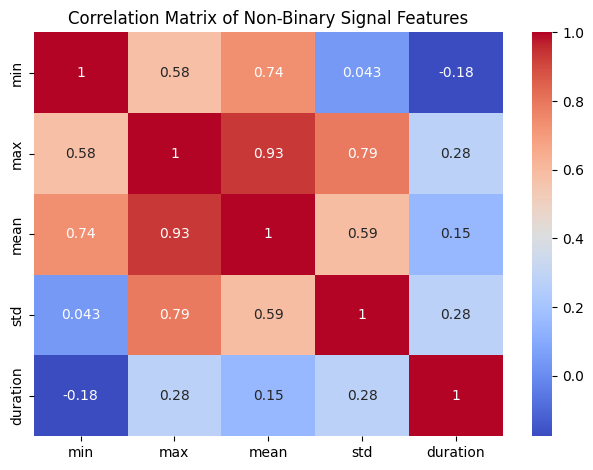

In [73]:
# 🧮 Filter only the non-binary-looking signals
nonbinary_df = trace_stats_df[trace_stats_df["looks_binary"] == False]

# 🧼 Keep only numeric columns
nonbinary_numeric = nonbinary_df.select_dtypes(include=["number"])

# 📊 Plot correlation heatmap
sns.heatmap(nonbinary_numeric.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix of Non-Binary Signal Features")
plt.tight_layout()
plt.show()


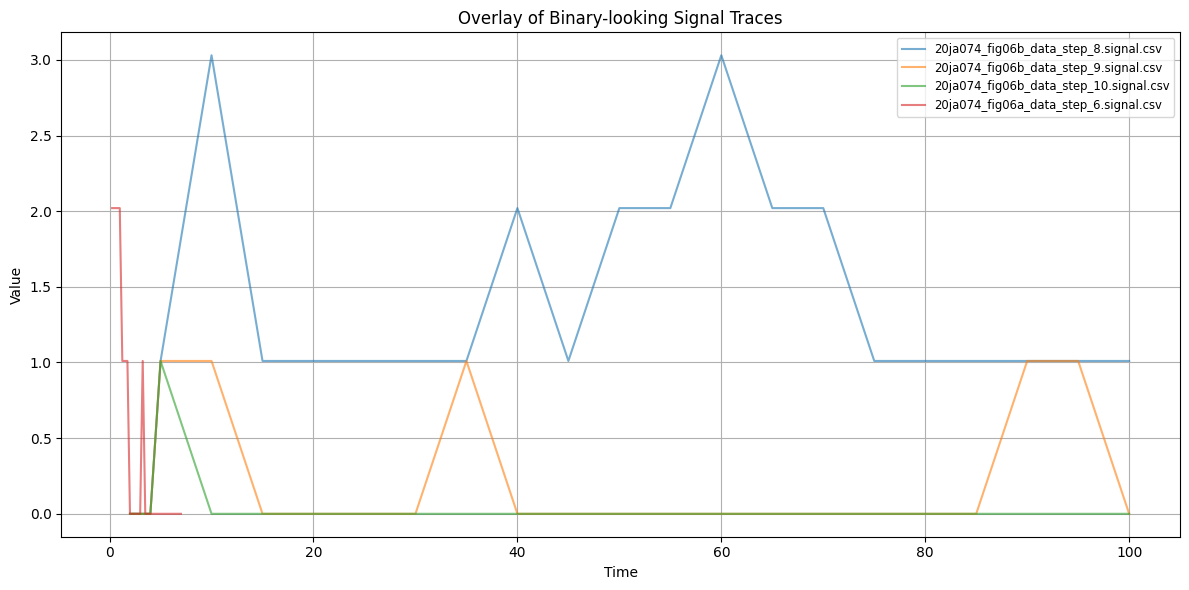

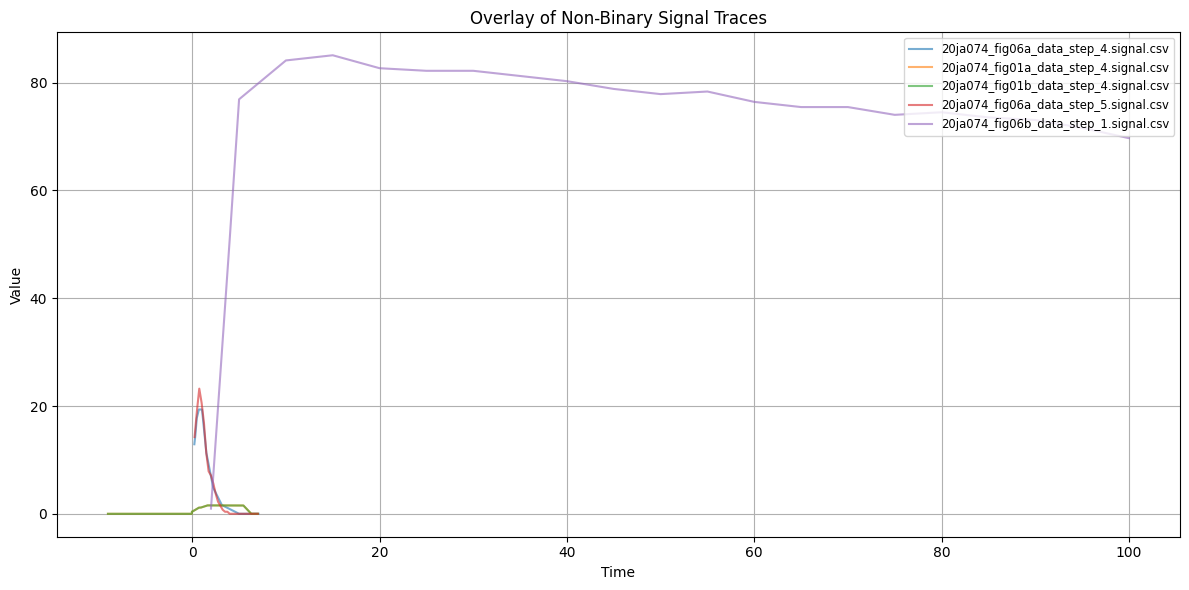

In [74]:
# Group binary and non-binary file paths
binary_paths = trace_stats_df[trace_stats_df['looks_binary'] == True]['trace_id'].tolist()
nonbinary_paths = trace_stats_df[trace_stats_df['looks_binary'] == False]['trace_id'].tolist()

# Helper to plot a few traces
def plot_traces(file_list, title, n=5):
    plt.figure(figsize=(12, 6))
    for path in file_list[:n]:
        df = pd.read_csv(f"traces_out/{path}")
        plt.plot(df['time'], df['value'], alpha=0.6, label=path)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend(fontsize='small', loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot binary traces
plot_traces(binary_paths, "Overlay of Binary-looking Signal Traces")

# Plot non-binary traces
plot_traces(nonbinary_paths, "Overlay of Non-Binary Signal Traces")


In [77]:
import os
import pandas as pd
import numpy as np
from scipy.stats import entropy
import matplotlib.pyplot as plt

# Set path to the directory with signal files
signal_dir = "traces_out"

# List all signal files
all_files = [f for f in os.listdir(signal_dir) if f.endswith(".signal.csv")]

# Entropy calculator function
def compute_entropy(signal_values, bins=10):
    signal_values = signal_values[~np.isnan(signal_values)]  # remove NaNs
    if len(signal_values) == 0:
        return np.nan
    hist, _ = np.histogram(signal_values, bins=bins, density=True)
    hist = hist[hist > 0]  # Remove zeros to avoid log(0)
    return entropy(hist, base=2)


# Store entropy results
entropy_data = []

for file in all_files:
    file_path = os.path.join(signal_dir, file)
    try:
        df = pd.read_csv(file_path)
        if "value" in df.columns:
            ent = compute_entropy(df["value"].values)
            entropy_data.append({"file": file, "entropy": ent})
    except Exception as e:
        print(f"Failed to read or process {file}: {e}")

# Convert to DataFrame
entropy_df = pd.DataFrame(entropy_data)

# Sort and display top signals by entropy
entropy_df_sorted = entropy_df.sort_values(by="entropy", ascending=False).reset_index(drop=True)


# Return for reference
entropy_df_sorted.head(10)


,file,entropy
0,20ja074_fig08b_data_step_3.signal.csv,2.921928
1,20ja074_fig06b_data_step_3.signal.csv,2.901947
2,20ja074_fig06a_data_step_2.signal.csv,2.775432
3,20ja074_fig01a_data_step_2.signal.csv,2.774165
4,20ja074_fig01b_data_step_2.signal.csv,2.774165
5,20ja074_fig06a_data_step_3.signal.csv,2.729469
6,20ja074_fig06b_data_step_4.signal.csv,2.651503
7,20ja074_fig08a_data_step_2.signal.csv,2.646439
8,20ja074_fig06b_data_step_6.signal.csv,2.515300
9,20ja074_fig01b_data_step_1.signal.csv,2.469113


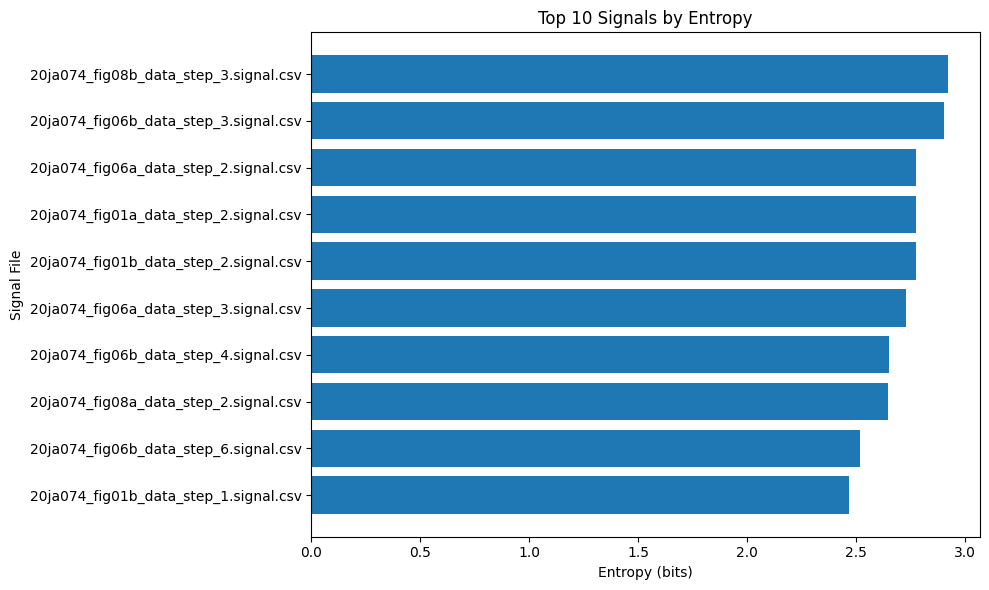

In [78]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(entropy_df_sorted["file"].head(10), entropy_df_sorted["entropy"].head(10))
plt.xlabel("Entropy (bits)")
plt.ylabel("Signal File")
plt.title("Top 10 Signals by Entropy")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [79]:
high_entropy_files = entropy_df_sorted.head(3)["file"]
low_entropy_files = entropy_df_sorted.tail(3)["file"]
